# This notebook demonstrates plotting the number density of MCS on a map
## It uses MCS track statistics file and counts each unique MCS located on a 1x1 degree grid once

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from itertools import chain
import copy
%matplotlib inline

In [2]:
# Sepcify directory of the MCS track stats file
rootdir = '/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/'

# Specify the years
# years = [2010, 2015, 2018]
years = [2018]
gpmfiles = []
wrffiles = []
for yy in years:
    gpmfiles = gpmfiles + sorted(glob.glob(f'{rootdir}GPM/stats/mcs_tracks_final_{yy}*.nc'))
    wrffiles = wrffiles + sorted(glob.glob(f'{rootdir}WRF/stats/mcs_tracks_final_{yy}*.nc'))
nyears_obs = len(gpmfiles)
nyears_wrf = len(wrffiles)
print(f'Number of years (OBS): {nyears_obs}')
print(f'Number of years (WRF): {nyears_wrf}')

# topfile = '/global/project/projectdirs/m1657/zfeng/SAAG/map_data/wrf_landmask_reg2imerg.nc'

figdir = f'/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/figures/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

Number of years (OBS): 1
Number of years (WRF): 1
/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/figures/


In [3]:
gpmfiles, wrffiles

(['/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/GPM/stats/mcs_tracks_final_20180601.0000_20190601.0000.nc'],
 ['/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/WRF/stats/mcs_tracks_final_20180601.0000_20190601.0000.nc'])

# Functions to count MCS on a grid

In [4]:
def get_unique_placements(track_num, lat, lon, ntimes):
    """
    Get unique pairs of lat/lon for a track
    """
    # Put all lat/lon pairs over each time for a track into an array
    this_row = np.array([[lat[track_num, tt], lon[track_num, tt]] for tt in range(0, ntimes)])
    # Return the unique pairs (axis=0)
    return np.array(np.unique(this_row, axis=0))

def count_unique_mcs(lat, lon, xbins, ybins):
    
    ntracks, ntimes = lat.shape

    # A function to loop over tracks
    get_unique = lambda D: get_unique_placements(D, lat, lon, ntimes)

    # Loop over each track and get the unique pairs of lat/lon
    all_uniques = list(map(get_unique, np.arange(0, ntracks)))

    # Flatten the list of lat/lon pairs (using chain), and convert into an array
    unique_latlon = np.array(list(chain(*all_uniques)))

    # Count number on map using histogram2d
    ranges = [[min(ybins), max(ybins)], [min(xbins), max(xbins)]]
    hist2d, yedges, xedges = np.histogram2d(unique_latlon[:,0], unique_latlon[:,1], bins=[ybins, xbins], range=ranges)

    return hist2d

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """ Truncate colormap.
    """
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [5]:
# # Read topography data
# dstop = xr.open_dataset(topfile)
# # Convert surface geopotential to height in meters
# ter = dstop.HGT.squeeze()
# landmask = dstop.LANDMASK.squeeze()
# ter_s = gaussian_filter(ter, 1)
# lon_ter = dstop.lon
# lat_ter = dstop.lat
# dstop

In [6]:
# Read GPM data
dsobs = xr.open_mfdataset(gpmfiles, concat_dim='tracks', combine='nested')
# Renumber the tracks so they are unique
ntracks_obs = dsobs.dims['tracks']
dsobs['tracks'] = np.arange(0, ntracks_obs)

/global/common/software/m1867/python/pyflex/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [7]:
# Read WRF data
dswrf = xr.open_mfdataset(wrffiles, concat_dim='tracks', combine='nested')
# Renumber the tracks so they are unique
ntracks_wrf = dswrf.dims['tracks']
dswrf['tracks'] = np.arange(0, ntracks_wrf)

/global/common/software/m1867/python/pyflex/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [8]:
# Define a lat/lon grid for counting MCS
lonmin, lonmax = -82., -33.1
latmin, latmax = -56., 13.1
xbins = np.arange(lonmin, lonmax, 1)
ybins = np.arange(latmin, latmax, 1)

In [9]:
# Get track initial time valuees
base_time_obs = dsobs.base_time.load()
starttime_obs = base_time_obs.isel(times=0)
syear_obs = starttime_obs.dt.year.load()
season_obs = starttime_obs.dt.season.load()
start_split_cloudnumber_obs = dsobs.start_split_cloudnumber.load()
# nyears_obs = len(np.unique(syear_obs))
# print(f'Number of unique years (OBS): {nyears_obs}')
ntracks_obs = dsobs.dims['tracks']
print(f'Number MCS (OBS): {ntracks_obs}')

Number MCS (OBS): 4632


/global/common/software/m1867/python/pyflex/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [10]:
# Get track initial time valuees
base_time_wrf = dswrf.base_time.load()
starttime_wrf = base_time_wrf.isel(times=0)
syear_wrf = starttime_wrf.dt.year.load()
season_wrf = starttime_wrf.dt.season.load()
start_split_cloudnumber_wrf = dswrf.start_split_cloudnumber.load()
# nyears_wrf = len(np.unique(syear_wrf))
# print(f'Number of unique years (wrf): {nyears_wrf}')
ntracks_wrf = dswrf.dims['tracks']
print(f'Number MCS (WRF): {ntracks_wrf}')

Number MCS (WRF): 3484


/global/common/software/m1867/python/pyflex/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [11]:
# Round the lat/lon to the nearest integer, 
# This way the lat/lon are calculated at the precision of 1 degree (i.e., count on a 1x1 degree grid)
# Note: counting using histogram2d only works on 1x1 degree grid (unique lat/lon are round to integer)
rlat_obs = dsobs.meanlat.load().round()
rlon_obs = dsobs.meanlon.load().round()

rlat_wrf = dswrf.meanlat.load().round()
# Convert WRF longitudes from 0~360 to -180~+180 to be consistent with OBS
rlon_wrf = ((dswrf.meanlon.load().round() - 180) % 360) - 180

In [13]:
# Separate tracks by season
rlat_obs_DJF = rlat_obs.where(season_obs == 'DJF', drop=False)
rlon_obs_DJF = rlon_obs.where(season_obs == 'DJF', drop=False)
rlat_obs_MAM = rlat_obs.where(season_obs == 'MAM', drop=False)
rlon_obs_MAM = rlon_obs.where(season_obs == 'MAM', drop=False)
rlat_obs_JJA = rlat_obs.where(season_obs == 'JJA', drop=False)
rlon_obs_JJA = rlon_obs.where(season_obs == 'JJA', drop=False)
rlat_obs_SON = rlat_obs.where(season_obs == 'SON', drop=False)
rlon_obs_SON = rlon_obs.where(season_obs == 'SON', drop=False)

rlat_wrf_DJF = rlat_wrf.where(season_wrf == 'DJF', drop=False)
rlon_wrf_DJF = rlon_wrf.where(season_wrf == 'DJF', drop=False)
rlat_wrf_MAM = rlat_wrf.where(season_wrf == 'MAM', drop=False)
rlon_wrf_MAM = rlon_wrf.where(season_wrf == 'MAM', drop=False)
rlat_wrf_JJA = rlat_wrf.where(season_wrf == 'JJA', drop=False)
rlon_wrf_JJA = rlon_wrf.where(season_wrf == 'JJA', drop=False)
rlat_wrf_SON = rlat_wrf.where(season_wrf == 'SON', drop=False)
rlon_wrf_SON = rlon_wrf.where(season_wrf == 'SON', drop=False)

In [14]:
# Total MCS count
mcs_ircount_obs = count_unique_mcs(rlat_obs.values, rlon_obs.values, xbins, ybins)
mcs_ircount_wrf = count_unique_mcs(rlat_wrf.values, rlon_wrf.values, xbins, ybins)

In [15]:
# Total MCS count by season
mcs_ircount_obs_DJF = count_unique_mcs(rlat_obs_DJF.values, rlon_obs_DJF.values, xbins, ybins)
mcs_ircount_obs_MAM = count_unique_mcs(rlat_obs_MAM.values, rlon_obs_MAM.values, xbins, ybins)
mcs_ircount_obs_JJA = count_unique_mcs(rlat_obs_JJA.values, rlon_obs_JJA.values, xbins, ybins)
mcs_ircount_obs_SON = count_unique_mcs(rlat_obs_SON.values, rlon_obs_SON.values, xbins, ybins)

In [16]:
mcs_ircount_wrf_DJF = count_unique_mcs(rlat_wrf_DJF.values, rlon_wrf_DJF.values, xbins, ybins)
mcs_ircount_wrf_MAM = count_unique_mcs(rlat_wrf_MAM.values, rlon_wrf_MAM.values, xbins, ybins)
mcs_ircount_wrf_JJA = count_unique_mcs(rlat_wrf_JJA.values, rlon_wrf_JJA.values, xbins, ybins)
mcs_ircount_wrf_SON = count_unique_mcs(rlat_wrf_SON.values, rlon_wrf_SON.values, xbins, ybins)

In [17]:
# Divide by the number of years to get annual mean
mcs_irnumber_obs = mcs_ircount_obs / nyears_obs
mcs_irnumber_wrf = mcs_ircount_wrf / nyears_wrf

In [18]:
mcs_irnumber_obs_DJF = mcs_ircount_obs_DJF / nyears_obs
mcs_irnumber_obs_MAM = mcs_ircount_obs_MAM / nyears_obs
mcs_irnumber_obs_JJA = mcs_ircount_obs_JJA / nyears_obs
mcs_irnumber_obs_SON = mcs_ircount_obs_SON / nyears_obs

In [19]:
mcs_irnumber_wrf_DJF = mcs_ircount_wrf_DJF / nyears_wrf
mcs_irnumber_wrf_MAM = mcs_ircount_wrf_MAM / nyears_wrf
mcs_irnumber_wrf_JJA = mcs_ircount_wrf_JJA / nyears_wrf
mcs_irnumber_wrf_SON = mcs_ircount_wrf_SON / nyears_wrf

In [20]:
# Exclude split tracks [split cloudnumber = NaN]
lat0_obs = dsobs.meanlat.isel(times=0).where(np.isnan(start_split_cloudnumber_obs), drop=True)
lon0_obs = dsobs.meanlon.isel(times=0).where(np.isnan(start_split_cloudnumber_obs), drop=True)
lat0_wrf = dswrf.meanlat.isel(times=0).where(np.isnan(start_split_cloudnumber_wrf), drop=True)
lon0_wrf = dswrf.meanlon.isel(times=0).where(np.isnan(start_split_cloudnumber_wrf), drop=True)
# Convert [0-360] to [-180~+180]
lon0_wrf = (lon0_wrf - 180) % 360 - 180

# Make a coarser resolution grid for initiation
xbins_c = np.arange(lonmin, lonmax, 3)
ybins_c = np.arange(latmin, latmax, 3)
ranges_c = [[min(ybins_c), max(ybins_c)], [min(xbins_c), max(xbins_c)]]
mcs_initcount_obs, yedges, xedges = np.histogram2d(lat0_obs, lon0_obs, bins=[ybins_c, xbins_c], range=ranges_c)
mcs_initcount_wrf, yedges, xedges = np.histogram2d(lat0_wrf, lon0_wrf, bins=[ybins_c, xbins_c], range=ranges_c)

mcs_initcount_obs = mcs_initcount_obs / nyears_obs
mcs_initcount_wrf = mcs_initcount_wrf / nyears_wrf

In [21]:
# Separate by season, exclude split tracks [split cloudnumber = NaN]
lat0_obs_DJF = lat0_obs.where((season_obs == 'DJF') & np.isnan(start_split_cloudnumber_obs), drop=True)
lon0_obs_DJF = lon0_obs.where((season_obs == 'DJF') & np.isnan(start_split_cloudnumber_obs), drop=True)
lat0_obs_MAM = lat0_obs.where((season_obs == 'MAM') & np.isnan(start_split_cloudnumber_obs), drop=True)
lon0_obs_MAM = lon0_obs.where((season_obs == 'MAM') & np.isnan(start_split_cloudnumber_obs), drop=True)
lat0_obs_JJA = lat0_obs.where((season_obs == 'JJA') & np.isnan(start_split_cloudnumber_obs), drop=True)
lon0_obs_JJA = lon0_obs.where((season_obs == 'JJA') & np.isnan(start_split_cloudnumber_obs), drop=True)
lat0_obs_SON = lat0_obs.where((season_obs == 'SON') & np.isnan(start_split_cloudnumber_obs), drop=True)
lon0_obs_SON = lon0_obs.where((season_obs == 'SON') & np.isnan(start_split_cloudnumber_obs), drop=True)

# For initiation, each MCS only has one pairs of lat/lon, so a 2D histogram works fine
mcs_initcount_obs_DJF, yedges, xedges = np.histogram2d(lat0_obs_DJF, lon0_obs_DJF, bins=[ybins_c, xbins_c], range=ranges_c)
mcs_initcount_obs_MAM, yedges, xedges = np.histogram2d(lat0_obs_MAM, lon0_obs_MAM, bins=[ybins_c, xbins_c], range=ranges_c)
mcs_initcount_obs_JJA, yedges, xedges = np.histogram2d(lat0_obs_JJA, lon0_obs_JJA, bins=[ybins_c, xbins_c], range=ranges_c)
mcs_initcount_obs_SON, yedges, xedges = np.histogram2d(lat0_obs_SON, lon0_obs_SON, bins=[ybins_c, xbins_c], range=ranges_c)

mcs_initcount_obs_DJF = mcs_initcount_obs_DJF / nyears_obs
mcs_initcount_obs_MAM = mcs_initcount_obs_MAM / nyears_obs
mcs_initcount_obs_JJA = mcs_initcount_obs_JJA / nyears_obs
mcs_initcount_obs_SON = mcs_initcount_obs_SON / nyears_obs

In [22]:
# Separate by season, exclude split tracks [split cloudnumber = NaN]
lat0_wrf_DJF = lat0_wrf.where((season_wrf == 'DJF') & np.isnan(start_split_cloudnumber_wrf), drop=True)
lon0_wrf_DJF = lon0_wrf.where((season_wrf == 'DJF') & np.isnan(start_split_cloudnumber_wrf), drop=True)
lat0_wrf_MAM = lat0_wrf.where((season_wrf == 'MAM') & np.isnan(start_split_cloudnumber_wrf), drop=True)
lon0_wrf_MAM = lon0_wrf.where((season_wrf == 'MAM') & np.isnan(start_split_cloudnumber_wrf), drop=True)
lat0_wrf_JJA = lat0_wrf.where((season_wrf == 'JJA') & np.isnan(start_split_cloudnumber_wrf), drop=True)
lon0_wrf_JJA = lon0_wrf.where((season_wrf == 'JJA') & np.isnan(start_split_cloudnumber_wrf), drop=True)
lat0_wrf_SON = lat0_wrf.where((season_wrf == 'SON') & np.isnan(start_split_cloudnumber_wrf), drop=True)
lon0_wrf_SON = lon0_wrf.where((season_wrf == 'SON') & np.isnan(start_split_cloudnumber_wrf), drop=True)

mcs_initcount_wrf_DJF, yedges, xedges = np.histogram2d(lat0_wrf_DJF, lon0_wrf_DJF, bins=[ybins_c, xbins_c], range=ranges_c)
mcs_initcount_wrf_MAM, yedges, xedges = np.histogram2d(lat0_wrf_MAM, lon0_wrf_MAM, bins=[ybins_c, xbins_c], range=ranges_c)
mcs_initcount_wrf_JJA, yedges, xedges = np.histogram2d(lat0_wrf_JJA, lon0_wrf_JJA, bins=[ybins_c, xbins_c], range=ranges_c)
mcs_initcount_wrf_SON, yedges, xedges = np.histogram2d(lat0_wrf_SON, lon0_wrf_SON, bins=[ybins_c, xbins_c], range=ranges_c)

mcs_initcount_wrf_DJF = mcs_initcount_wrf_DJF / nyears_wrf
mcs_initcount_wrf_MAM = mcs_initcount_wrf_MAM / nyears_wrf
mcs_initcount_wrf_JJA = mcs_initcount_wrf_JJA / nyears_wrf
mcs_initcount_wrf_SON = mcs_initcount_wrf_SON / nyears_wrf

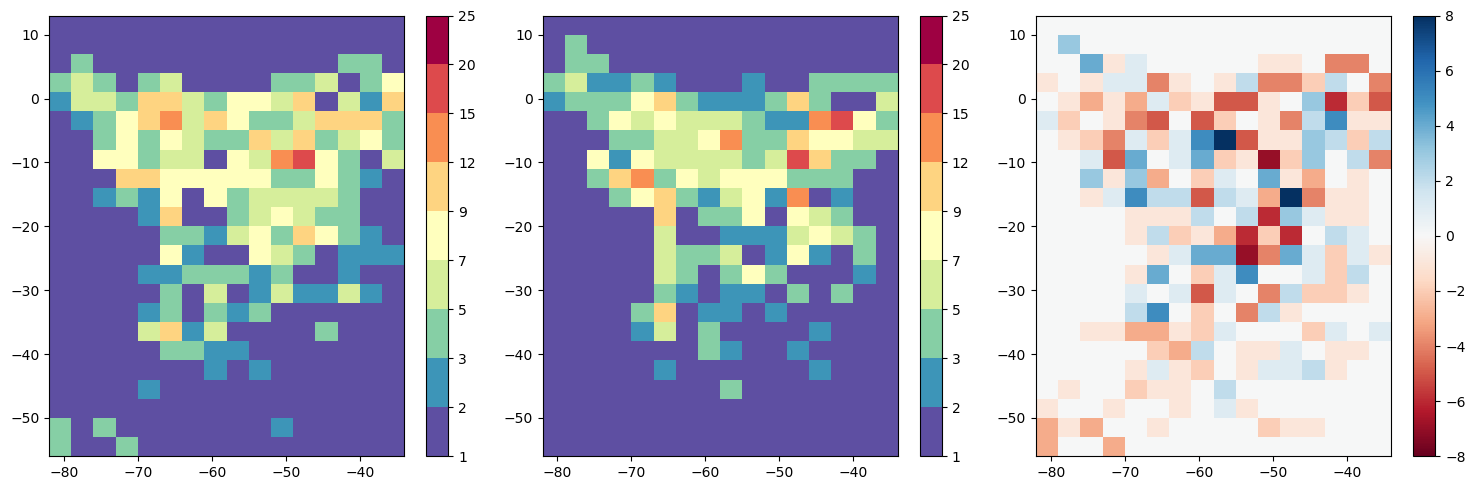

In [23]:
fig, ax = plt.subplots(ncols=3, figsize=[15,5], dpi=100)
levels = [1,2,3,5,7,9,12,15,20,25]
cmap = copy.copy(mpl.colormaps.get_cmap("Spectral_r"))
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=256)
mcs_initcount_diff_DJF = mcs_initcount_wrf_DJF - mcs_initcount_obs_DJF
pm1 = ax[0].pcolormesh(xbins_c, ybins_c, mcs_initcount_obs_DJF, shading='auto', norm=norm, cmap=cmap)
pm2 = ax[1].pcolormesh(xbins_c, ybins_c, mcs_initcount_wrf_DJF, shading='auto', norm=norm, cmap=cmap)
pm3 = ax[2].pcolormesh(xbins_c, ybins_c, mcs_initcount_diff_DJF, shading='auto', vmin=-8, vmax=8, cmap='RdBu')
plt.colorbar(pm1, ax=ax[0])
plt.colorbar(pm2, ax=ax[1])
plt.colorbar(pm3, ax=ax[2])
fig.tight_layout()

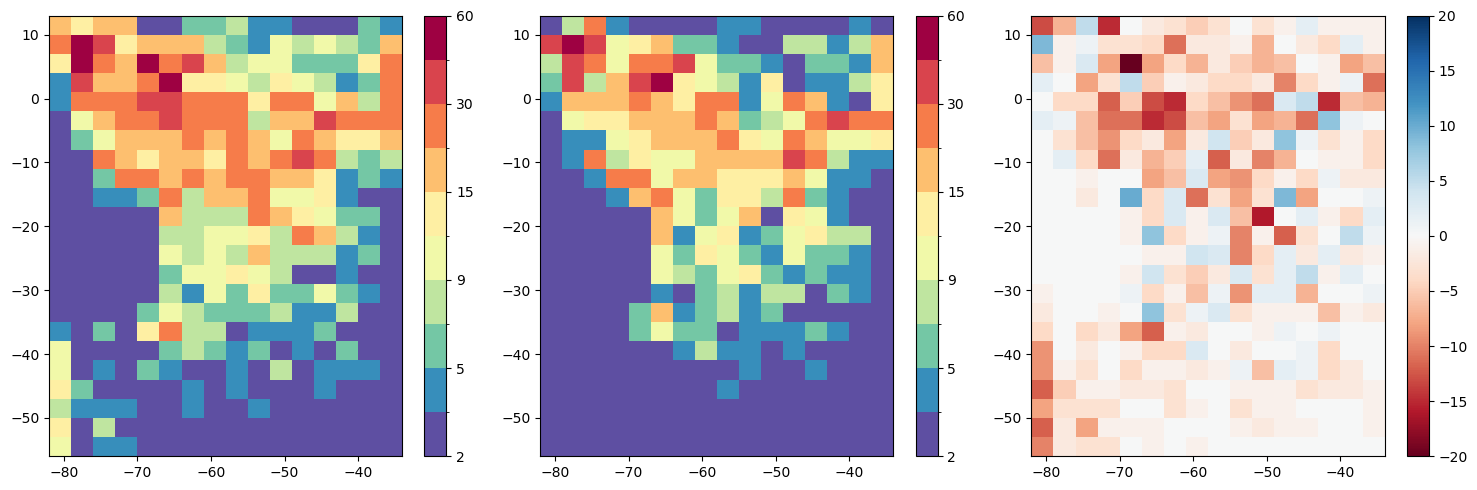

In [24]:
fig, ax = plt.subplots(ncols=3, figsize=[15,5], dpi=100)
levels = [2,3,5,7,9,12,15,20,30,40,60]
cmap = copy.copy(mpl.colormaps.get_cmap("Spectral_r"))
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=256)
mcs_initcount_diff = mcs_initcount_wrf - mcs_initcount_obs
pm1 = ax[0].pcolormesh(xbins_c, ybins_c, mcs_initcount_obs, shading='auto', norm=norm, cmap=cmap)
pm2 = ax[1].pcolormesh(xbins_c, ybins_c, mcs_initcount_wrf, shading='auto', norm=norm, cmap=cmap)
pm3 = ax[2].pcolormesh(xbins_c, ybins_c, mcs_initcount_diff, shading='auto', vmin=-20, vmax=20, cmap='RdBu')
plt.colorbar(pm1, ax=ax[0])
plt.colorbar(pm2, ax=ax[1])
plt.colorbar(pm3, ax=ax[2])
fig.tight_layout()

In [25]:
mcs_initcount_diff.shape, xbins.shape, ybins.shape

((23, 16), (49,), (70,))

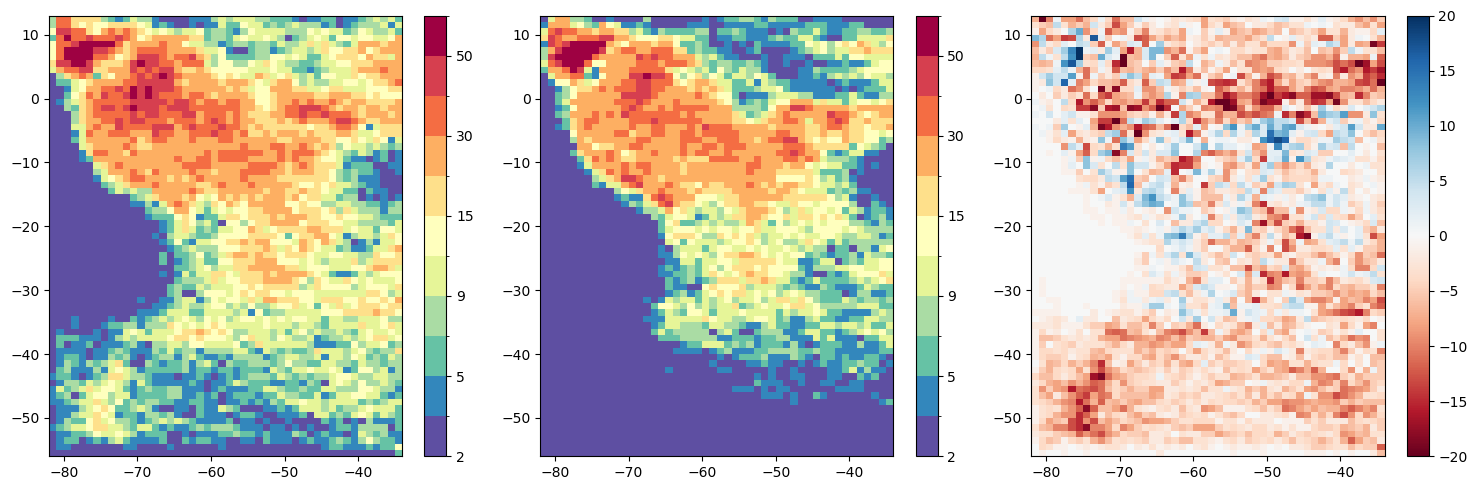

In [26]:
fig, ax = plt.subplots(ncols=3, figsize=[15,5], dpi=100)
levels = [2,3,5,7,9,12,15,20,30,40,50,60]
cmap = copy.copy(mpl.colormaps.get_cmap("Spectral_r"))
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=256)
mcs_irnumber_diff = mcs_irnumber_wrf - mcs_irnumber_obs
pm1 = ax[0].pcolormesh(xbins, ybins, mcs_irnumber_obs, shading='auto', norm=norm, cmap=cmap)
pm2 = ax[1].pcolormesh(xbins, ybins, mcs_irnumber_wrf, shading='auto', norm=norm, cmap=cmap)
pm3 = ax[2].pcolormesh(xbins, ybins, mcs_irnumber_diff, shading='auto', vmin=-20, vmax=20, cmap='RdBu')
plt.colorbar(pm1, ax=ax[0])
plt.colorbar(pm2, ax=ax[1])
plt.colorbar(pm3, ax=ax[2])
fig.tight_layout()

In [27]:
def plot_map_3panels(dataarray, lonarray, latarray, levels, cmaps, titles, cblabels, cbticks, figname, oob_colors=None):
    
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'

    map_extend = [-82, -34, -56, 13]
    lonv = np.arange(-80,-30.1,10)
    latv = np.arange(-50,10.1,10)
    proj = ccrs.PlateCarree()
    levelshgt = [1000,6000]
    resolution = '50m'
    land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
    borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)

    fig = plt.figure(figsize=[14,5.5], dpi=100)
    
    for pp in range(0,3):
        ax = plt.subplot(1, 3, pp+1, projection=proj)
        ax.set_extent(map_extend, crs=proj)
        ax.add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
        ax.add_feature(land, facecolor='none', edgecolor='k', zorder=3)
        ax.set_title(titles[pp], loc='left')
        ax.set_aspect('auto', adjustable=None)
        ax.set_title(titles[pp], loc='left')

        # Plot grid lines and lat/lon labels
        gl = ax.gridlines(crs=proj, draw_labels=False, linestyle='--', linewidth=0.5)
        gl.xlocator = mpl.ticker.FixedLocator(lonv)
        gl.ylocator = mpl.ticker.FixedLocator(latv)        
        ax.set_xticks(lonv, crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()        
        ax.xaxis.set_major_formatter(lon_formatter)
        if (pp == 0):
            ax.set_yticks(latv, crs=ccrs.PlateCarree())
            ax.yaxis.set_major_formatter(lat_formatter)            
        
        data = dataarray[pp]
        Zm = np.ma.masked_where(((np.isnan(data))), data)
        cmap = copy.copy(mpl.colormaps.get_cmap(cmaps[pp]))
        norm = mpl.colors.BoundaryNorm(boundaries=levels[pp], ncolors=cmap.N)
        cf1 = ax.pcolormesh(lonarray, latarray, Zm, shading='auto', norm=norm, cmap=cmap, transform=proj, zorder=2)
        if (oob_colors is not None) and (pp != 2):
            cf1.cmap.set_over(oob_colors['over'])
            cf1.cmap.set_under(oob_colors['under'])
            cf1.set_clim(min(levels[pp]), max(levels[pp]))
        cb1 = plt.colorbar(cf1, ax=ax, label=cblabels[pp], pad=0.02, ticks=cbticks[pp], extend='both', aspect=30)

        # # Terrain height
        # ct = ax.contour(lon_ter, lat_ter, ter, levels=levelshgt, \
        #                 colors='dimgray', linewidths=1, transform=proj, zorder=3)

    # Work around to make tight_layout work 
    fig.canvas.draw()
    fig.tight_layout(w_pad=0.15)
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

In [28]:
years = f'{syear_obs.min().item()}-{syear_obs.max().item()}'
years

'2018-2019'

In [29]:
figdir

'/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/figures/'

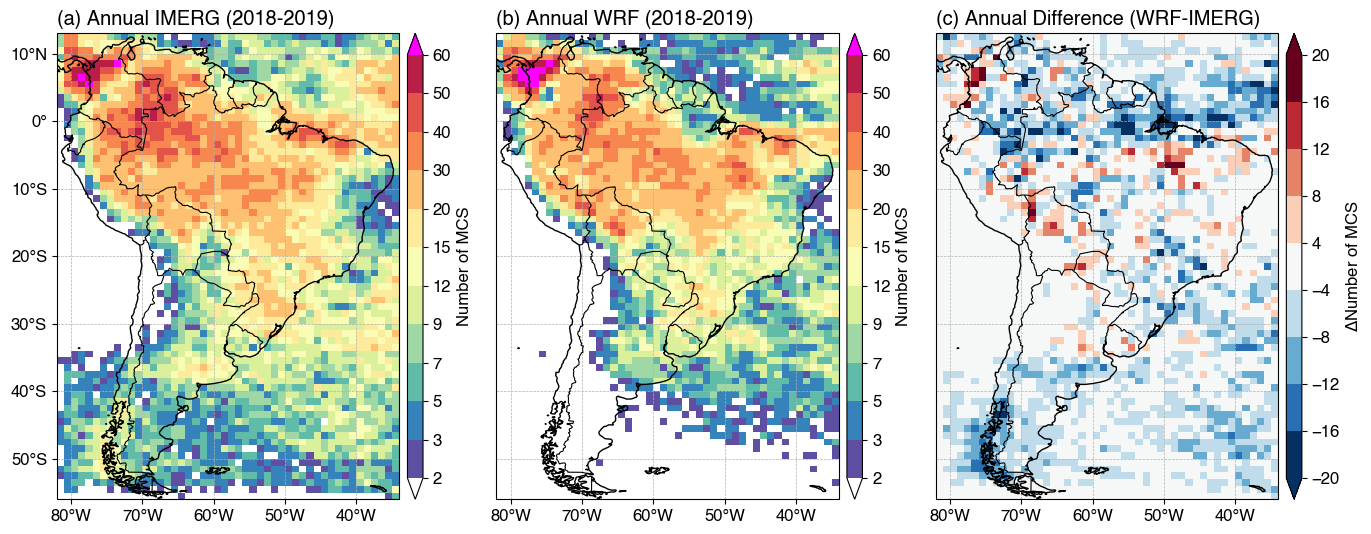

In [30]:
mcs_irnumber_diff = mcs_irnumber_wrf - mcs_irnumber_obs
dataarray = [mcs_irnumber_obs, mcs_irnumber_wrf, mcs_irnumber_diff]
levels = [2,3,5,7,9,12,15,20,30,40,50,60]
levelsdiff = np.arange(-20,20.1,4)
# Remove mid-point (0 value)
idx = int((len(levelsdiff)-1)/2)
levelsdiff = np.delete(levelsdiff, idx)
levels = [levels, levels, levelsdiff]
cmap = copy.copy(mpl.colormaps.get_cmap('Spectral_r'))
cmap = truncate_colormap(cmap, 0.0, 0.95)
cmapdiff = copy.copy(mpl.colormaps.get_cmap('RdBu_r'))
cmaps = [cmap,cmap,cmapdiff]
titles = [f'(a) Annual IMERG ({years})', f'(b) Annual WRF ({years})', f'(c) Annual Difference (WRF-IMERG)']
cblabels = ['Number of MCS','Number of MCS',r'$\Delta$'+'Number of MCS']
cbticks = levels
figname = f'{figdir}imerg_wrf_mcs_irnumber_map_annual_{years}.png'
oob_colors = {'under':'white', 'over':'magenta'}
fig = plot_map_3panels(dataarray, xbins, ybins, levels, cmaps, titles, cblabels, cbticks, figname, oob_colors=oob_colors)

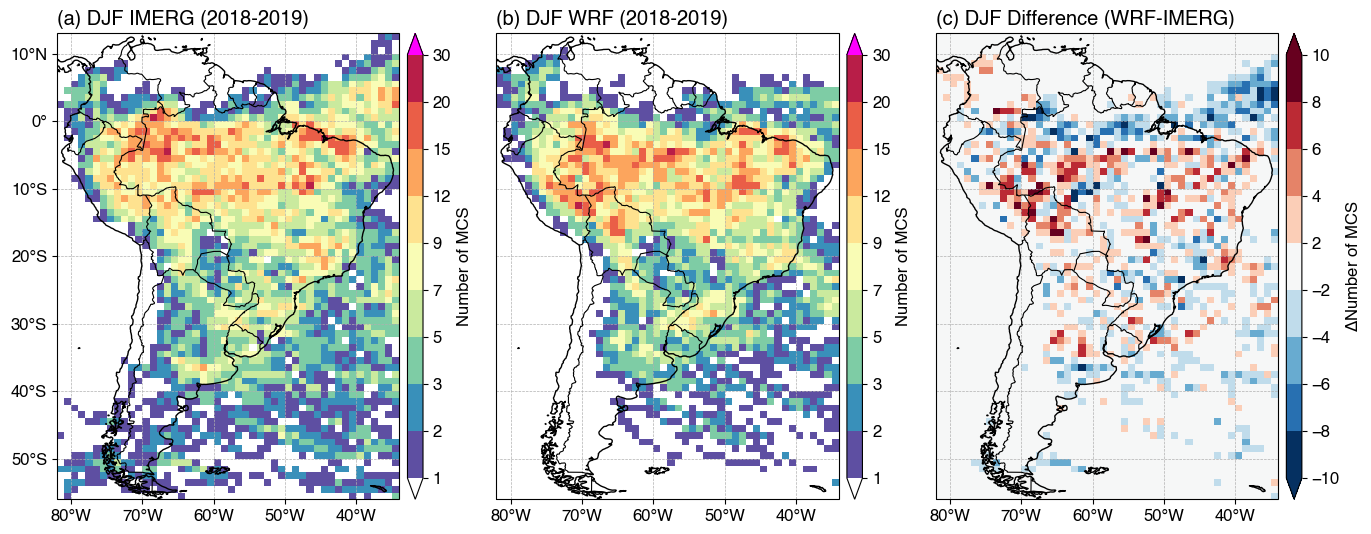

In [31]:
mcs_irnumber_diff_DJF = mcs_irnumber_wrf_DJF - mcs_irnumber_obs_DJF
dataarray = [mcs_irnumber_obs_DJF, mcs_irnumber_wrf_DJF, mcs_irnumber_diff_DJF]
levels = [1,2,3,5,7,9,12,15,20,30]
levelsdiff = np.arange(-10,10.1,2)
# Remove mid-point (0 value)
idx = int((len(levelsdiff)-1)/2)
levelsdiff = np.delete(levelsdiff, idx)
levels = [levels, levels, levelsdiff]
cmap = copy.copy(mpl.colormaps.get_cmap('Spectral_r'))
cmap = truncate_colormap(cmap, 0.0, 0.95)
cmapdiff = copy.copy(mpl.colormaps.get_cmap('RdBu_r'))
cmaps = [cmap,cmap,cmapdiff]
titles = [f'(a) DJF IMERG ({years})', f'(b) DJF WRF ({years})', f'(c) DJF Difference (WRF-IMERG)']
cblabels = ['Number of MCS','Number of MCS',r'$\Delta$'+'Number of MCS']
cbticks = levels
figname = f'{figdir}imerg_wrf_mcs_irnumber_map_DJF_{years}.png'
oob_colors = {'under':'white', 'over':'magenta'}
fig = plot_map_3panels(dataarray, xbins, ybins, levels, cmaps, titles, cblabels, cbticks, figname, oob_colors=oob_colors)

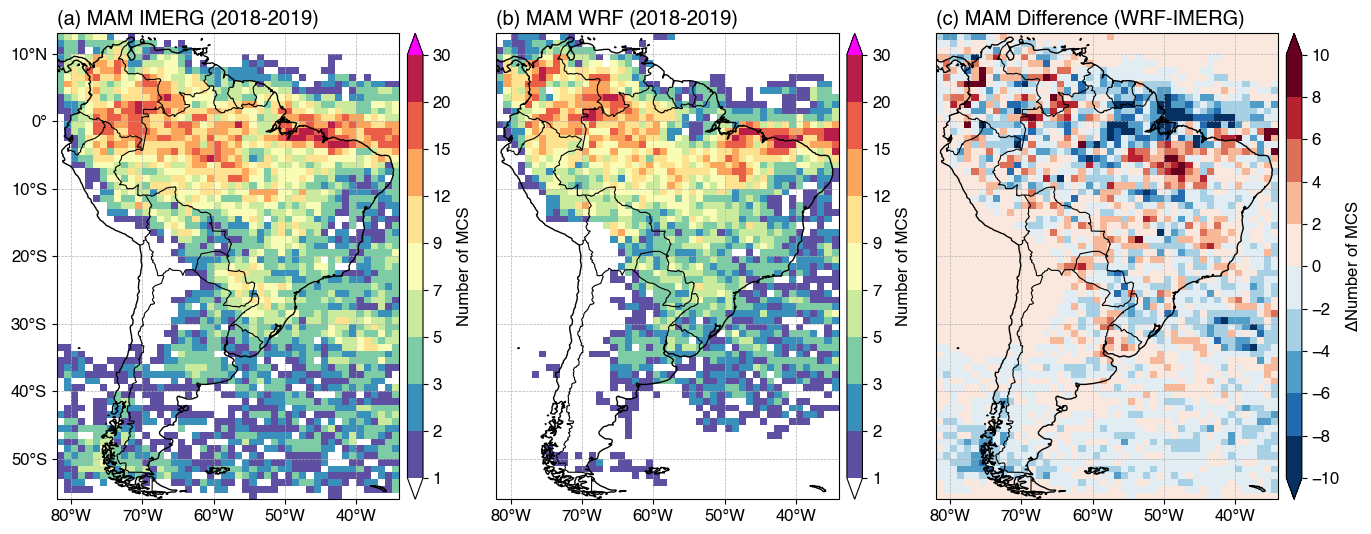

In [32]:
mcs_irnumber_diff_MAM = mcs_irnumber_wrf_MAM - mcs_irnumber_obs_MAM
dataarray = [mcs_irnumber_obs_MAM, mcs_irnumber_wrf_MAM, mcs_irnumber_diff_MAM]
levels = [1,2,3,5,7,9,12,15,20,30]
levelsdiff = np.arange(-10,10.1,2)
levels = [levels, levels, levelsdiff]
cmap = copy.copy(mpl.colormaps.get_cmap('Spectral_r'))
cmap = truncate_colormap(cmap, 0.0, 0.95)
cmapdiff = copy.copy(mpl.colormaps.get_cmap('RdBu_r'))
cmaps = [cmap,cmap,cmapdiff]
titles = [f'(a) MAM IMERG ({years})', f'(b) MAM WRF ({years})', f'(c) MAM Difference (WRF-IMERG)']
cblabels = ['Number of MCS','Number of MCS',r'$\Delta$'+'Number of MCS']
cbticks = levels
figname = f'{figdir}imerg_wrf_mcs_irnumber_map_MAM_{years}.png'
oob_colors = {'under':'white', 'over':'magenta'}
fig = plot_map_3panels(dataarray, xbins, ybins, levels, cmaps, titles, cblabels, cbticks, figname, oob_colors=oob_colors)

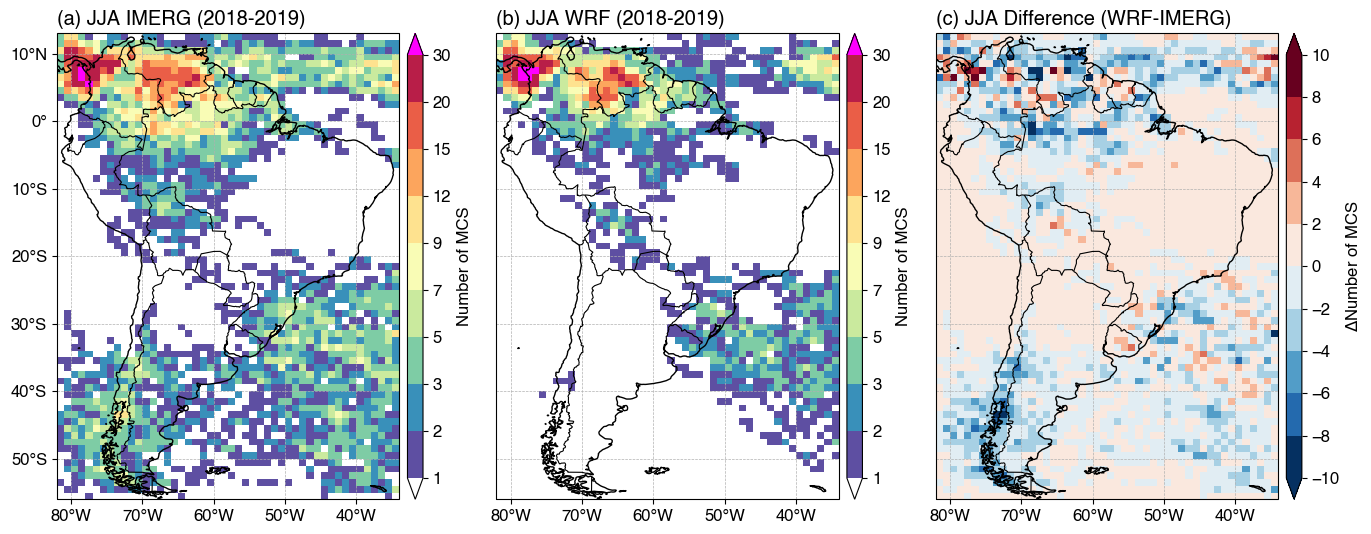

In [33]:
mcs_irnumber_diff_JJA = mcs_irnumber_wrf_JJA - mcs_irnumber_obs_JJA
dataarray = [mcs_irnumber_obs_JJA, mcs_irnumber_wrf_JJA, mcs_irnumber_diff_JJA]
levels = [1,2,3,5,7,9,12,15,20,30]
levelsdiff = np.arange(-10,10.1,2)
levels = [levels, levels, levelsdiff]
cmap = copy.copy(mpl.colormaps.get_cmap('Spectral_r'))
cmap = truncate_colormap(cmap, 0.0, 0.95)
cmapdiff = copy.copy(mpl.colormaps.get_cmap('RdBu_r'))
cmaps = [cmap,cmap,cmapdiff]
titles = [f'(a) JJA IMERG ({years})', f'(b) JJA WRF ({years})', f'(c) JJA Difference (WRF-IMERG)']
cblabels = ['Number of MCS','Number of MCS',r'$\Delta$'+'Number of MCS']
cbticks = levels
figname = f'{figdir}imerg_wrf_mcs_irnumber_map_JJA_{years}.png'
oob_colors = {'under':'white', 'over':'magenta'}
fig = plot_map_3panels(dataarray, xbins, ybins, levels, cmaps, titles, cblabels, cbticks, figname, oob_colors=oob_colors)

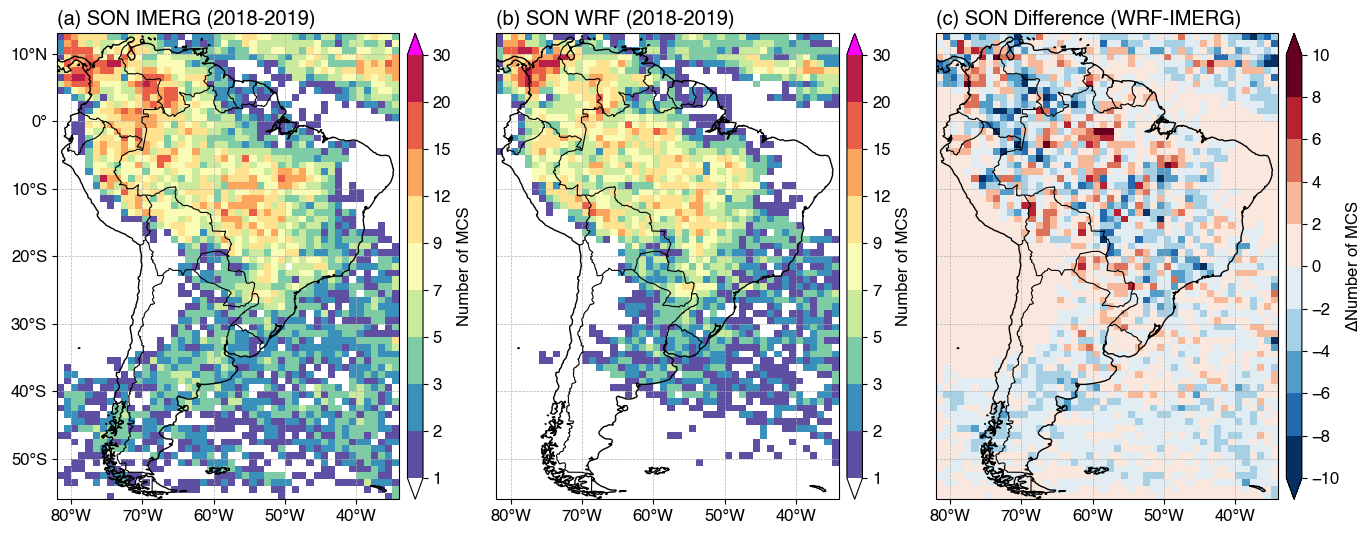

In [34]:
mcs_irnumber_diff_SON = mcs_irnumber_wrf_SON - mcs_irnumber_obs_SON
dataarray = [mcs_irnumber_obs_SON, mcs_irnumber_wrf_SON, mcs_irnumber_diff_SON]
levels = [1,2,3,5,7,9,12,15,20,30]
levelsdiff = np.arange(-10,10.1,2)
levels = [levels, levels, levelsdiff]
cmap = copy.copy(mpl.colormaps.get_cmap('Spectral_r'))
cmap = truncate_colormap(cmap, 0.0, 0.95)
cmapdiff = copy.copy(mpl.colormaps.get_cmap('RdBu_r'))
cmaps = [cmap,cmap,cmapdiff]
titles = [f'(a) SON IMERG ({years})', f'(b) SON WRF ({years})', f'(c) SON Difference (WRF-IMERG)']
cblabels = ['Number of MCS','Number of MCS',r'$\Delta$'+'Number of MCS']
cbticks = levels
figname = f'{figdir}imerg_wrf_mcs_irnumber_map_SON_{years}.png'
oob_colors = {'under':'white', 'over':'magenta'}
fig = plot_map_3panels(dataarray, xbins, ybins, levels, cmaps, titles, cblabels, cbticks, figname, oob_colors=oob_colors)

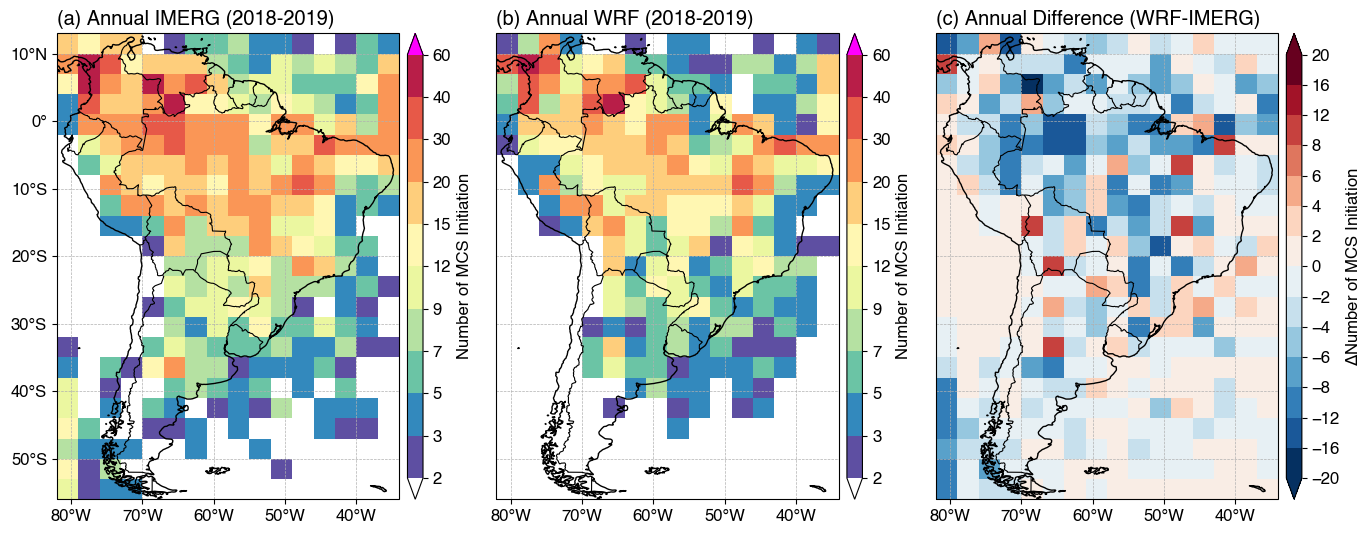

In [35]:
mcs_initcount_diff = mcs_initcount_wrf - mcs_initcount_obs
dataarray = [mcs_initcount_obs, mcs_initcount_wrf, mcs_initcount_diff]
levels = [2,3,5,7,9,12,15,20,30,40,60]
levelsdiff = [-20,-16,-12,-8,-6,-4,-2,0,2,4,6,8,12,16,20]
levels = [levels, levels, levelsdiff]
cmap = copy.copy(mpl.colormaps.get_cmap('Spectral_r'))
cmap = truncate_colormap(cmap, 0.0, 0.95)
cmapdiff = copy.copy(mpl.colormaps.get_cmap('RdBu_r'))
cmaps = [cmap,cmap,cmapdiff]
titles = [f'(a) Annual IMERG ({years})', f'(b) Annual WRF ({years})', f'(c) Annual Difference (WRF-IMERG)']
cblabels = ['Number of MCS Initiation','Number of MCS Initiation',r'$\Delta$'+'Number of MCS Initiation']
cbticks = levels
figname = f'{figdir}imerg_wrf_mcs_irinitiation_map_annual_{years}.png'
oob_colors = {'under':'white', 'over':'magenta'}
fig = plot_map_3panels(dataarray, xbins_c, ybins_c, levels, cmaps, titles, cblabels, cbticks, figname, oob_colors=oob_colors)

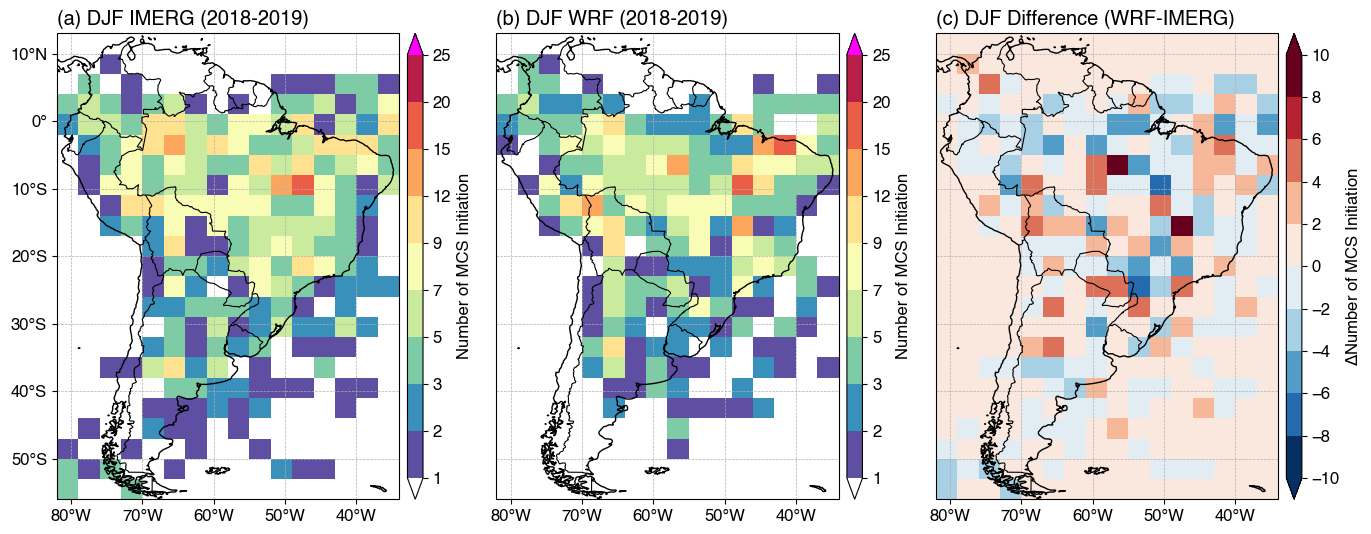

In [36]:
mcs_initcount_diff_DJF = mcs_initcount_wrf_DJF - mcs_initcount_obs_DJF
dataarray = [mcs_initcount_obs_DJF, mcs_initcount_wrf_DJF, mcs_initcount_diff_DJF]
levels = [1,2,3,5,7,9,12,15,20,25]
levelsdiff = [-10,-8,-6,-4,-2,0,2,4,6,8,10]
levels = [levels, levels, levelsdiff]
cmap = copy.copy(mpl.colormaps.get_cmap('Spectral_r'))
cmap = truncate_colormap(cmap, 0.0, 0.95)
cmapdiff = copy.copy(mpl.colormaps.get_cmap('RdBu_r'))
cmaps = [cmap,cmap,cmapdiff]
titles = [f'(a) DJF IMERG ({years})', f'(b) DJF WRF ({years})', f'(c) DJF Difference (WRF-IMERG)']
cblabels = ['Number of MCS Initiation','Number of MCS Initiation',r'$\Delta$'+'Number of MCS Initiation']
cbticks = levels
figname = f'{figdir}imerg_wrf_mcs_irinitiation_map_DJF_{years}.png'
oob_colors = {'under':'white', 'over':'magenta'}
fig = plot_map_3panels(dataarray, xbins_c, ybins_c, levels, cmaps, titles, cblabels, cbticks, figname, oob_colors=oob_colors)

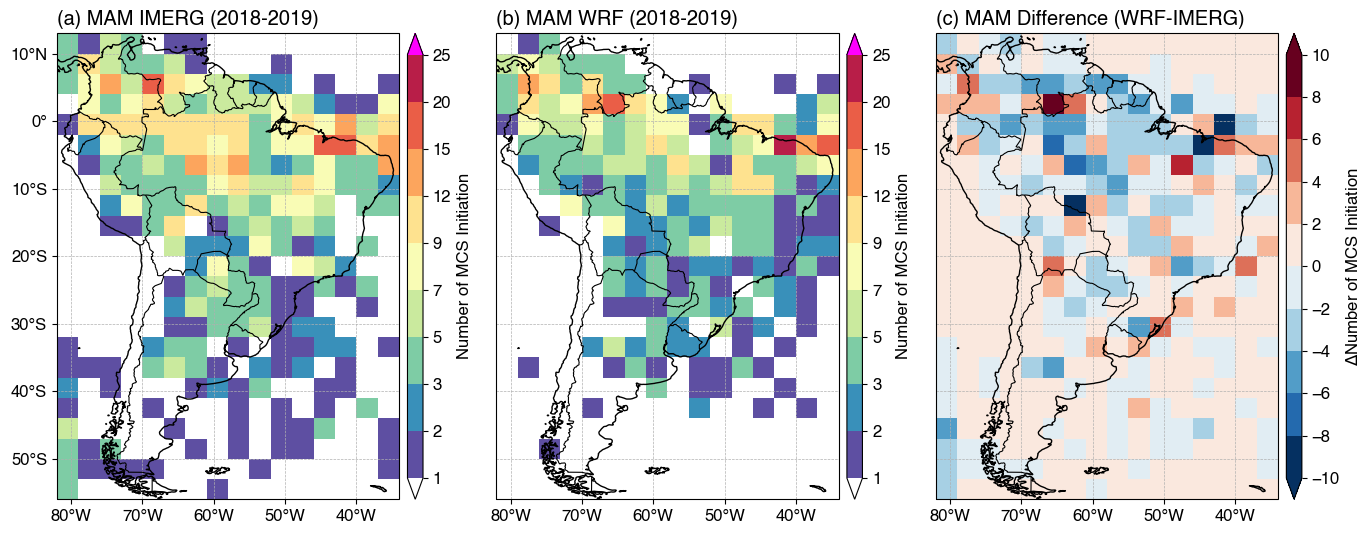

In [37]:
mcs_initcount_diff_MAM = mcs_initcount_wrf_MAM - mcs_initcount_obs_MAM
dataarray = [mcs_initcount_obs_MAM, mcs_initcount_wrf_MAM, mcs_initcount_diff_MAM]
levels = [1,2,3,5,7,9,12,15,20,25]
levelsdiff = [-10,-8,-6,-4,-2,0,2,4,6,8,10]
levels = [levels, levels, levelsdiff]
cmap = copy.copy(mpl.colormaps.get_cmap('Spectral_r'))
cmap = truncate_colormap(cmap, 0.0, 0.95)
cmapdiff = copy.copy(mpl.colormaps.get_cmap('RdBu_r'))
cmaps = [cmap,cmap,cmapdiff]
titles = [f'(a) MAM IMERG ({years})', f'(b) MAM WRF ({years})', f'(c) MAM Difference (WRF-IMERG)']
cblabels = ['Number of MCS Initiation','Number of MCS Initiation',r'$\Delta$'+'Number of MCS Initiation']
cbticks = levels
figname = f'{figdir}imerg_wrf_mcs_irinitiation_map_MAM_{years}.png'
oob_colors = {'under':'white', 'over':'magenta'}
fig = plot_map_3panels(dataarray, xbins_c, ybins_c, levels, cmaps, titles, cblabels, cbticks, figname, oob_colors=oob_colors)

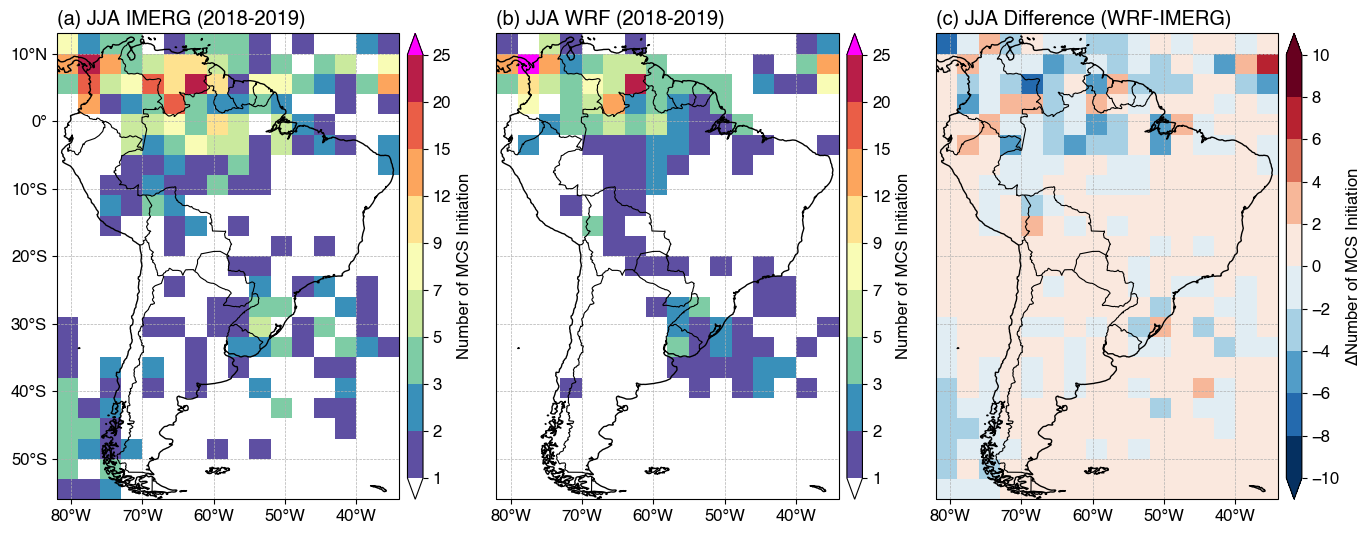

In [38]:
mcs_initcount_diff_JJA = mcs_initcount_wrf_JJA - mcs_initcount_obs_JJA
dataarray = [mcs_initcount_obs_JJA, mcs_initcount_wrf_JJA, mcs_initcount_diff_JJA]
levels = [1,2,3,5,7,9,12,15,20,25]
levelsdiff = [-10,-8,-6,-4,-2,0,2,4,6,8,10]
levels = [levels, levels, levelsdiff]
cmap = copy.copy(mpl.colormaps.get_cmap('Spectral_r'))
cmap = truncate_colormap(cmap, 0.0, 0.95)
cmapdiff = copy.copy(mpl.colormaps.get_cmap('RdBu_r'))
cmaps = [cmap,cmap,cmapdiff]
titles = [f'(a) JJA IMERG ({years})', f'(b) JJA WRF ({years})', f'(c) JJA Difference (WRF-IMERG)']
cblabels = ['Number of MCS Initiation','Number of MCS Initiation',r'$\Delta$'+'Number of MCS Initiation']
cbticks = levels
figname = f'{figdir}imerg_wrf_mcs_irinitiation_map_JJA_{years}.png'
oob_colors = {'under':'white', 'over':'magenta'}
fig = plot_map_3panels(dataarray, xbins_c, ybins_c, levels, cmaps, titles, cblabels, cbticks, figname, oob_colors=oob_colors)

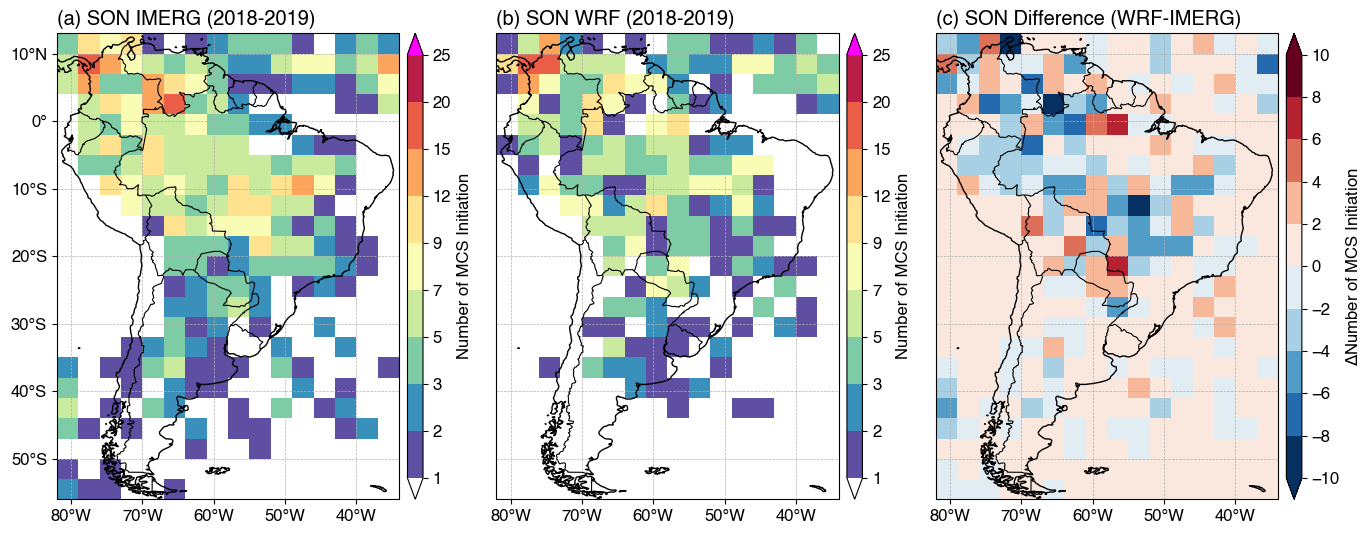

In [39]:
mcs_initcount_diff_SON = mcs_initcount_wrf_SON - mcs_initcount_obs_SON
dataarray = [mcs_initcount_obs_SON, mcs_initcount_wrf_SON, mcs_initcount_diff_SON]
levels = [1,2,3,5,7,9,12,15,20,25]
levelsdiff = [-10,-8,-6,-4,-2,0,2,4,6,8,10]
levels = [levels, levels, levelsdiff]
cmap = copy.copy(mpl.colormaps.get_cmap('Spectral_r'))
cmap = truncate_colormap(cmap, 0.0, 0.95)
cmapdiff = copy.copy(mpl.colormaps.get_cmap('RdBu_r'))
cmaps = [cmap,cmap,cmapdiff]
titles = [f'(a) SON IMERG ({years})', f'(b) SON WRF ({years})', f'(c) SON Difference (WRF-IMERG)']
cblabels = ['Number of MCS Initiation','Number of MCS Initiation',r'$\Delta$'+'Number of MCS Initiation']
cbticks = levels
figname = f'{figdir}imerg_wrf_mcs_irinitiation_map_SON_{years}.png'
oob_colors = {'under':'white', 'over':'magenta'}
fig = plot_map_3panels(dataarray, xbins_c, ybins_c, levels, cmaps, titles, cblabels, cbticks, figname, oob_colors=oob_colors)

In [40]:
figdir

'/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/figures/'